# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import cProfile
import pstats
import os
from pstats import SortKey

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

## Initial Guess Optimization

In [2]:
tree_by_slots = {}
slot_values = np.arange(5, 9, dtype=int)
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    print("Building tree")
    tree_file = "db/nerdle{}_tree.pkl".format(num_slots) 
    if os.path.exists(tree_file):
        with open(tree_file, 'rb') as f:
            tree = pickle.load(f)
    else:
        %time tree = analysis.GameTreeBuilder(solver_data).build()
        with open(tree_file, 'wb') as f:
            pickle.dump(tree, f)
    tree_by_slots[num_slots] = tree

num_slots 5
Building tree
num_slots 6
Building tree
num_slots 7
Building tree
num_slots 8
Building tree


In [3]:
freq_by_slots = {}
min_num_guesses, max_num_guesses = 2, 5
for num_slots in slot_values:
    tree = tree_by_slots[num_slots]
    tdc = TreeDepthCalculator(tree)
    # Distribution of #guesses for all answers.
    num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
    freq = collections.Counter(num_guesses)
    num_leaves = sum(1 for node in tdc.depth if not node.children)

    print("#slots {} Avg {:.2f} +- {:.2f} Best initial guess {} #nodes {} #leaves {}".format(
        num_slots, np.mean(num_guesses), np.std(num_guesses), tree.key[1], len(tdc.depth), num_leaves))
    freq_by_slots[num_slots] = [100 * freq[k] / num_leaves if k in freq else 0 for k in range(min_num_guesses, max_num_guesses+1)]
    for k, v in zip(range(min_num_guesses, max_num_guesses+1), freq_by_slots[num_slots]):
        print("{} guesses: {:6.2f}%".format(k, v))

NameError: name 'TreeDepthCalculator' is not defined

In [ ]:
labels = list(map(str, range(min_num_guesses, max_num_guesses+1)))

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects = [None] * num_slots
for i, num_slots in enumerate(slot_values):
    rects[i] = ax.bar(x + (i - 0.5 * len(slot_values)) * width, freq_by_slots[num_slots], width, label='{} Slots'.format(num_slots))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('# Guesses')
ax.set_ylabel('Frequency')
ax.set_title('#Guesses Distribution by Problem Size')
ax.set_xticks(x, labels)
ax.legend()
for i in range(len(slot_values)):
    ax.bar_label(rects[i], labels=["{:.0f}".format(x) for x in freq_by_slots[slot_values[i]]], padding=3)
#for rect in rects:
#    ax.bar_label(rect, padding=3)
fig.tight_layout()
plt.show()

In [ ]:
for num_slots in range(5, 9):
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db
    answers = solver_data.all_keys
    %time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
    b = collections.Counter(d[k]).values()
    print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
        solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))

* It seems like odd-size Nerdle is harder than even-size! Larger average #guesses.
* Diversifying symbols of initial guess is a generally good criterion.

In [4]:
num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

num_slots 7


In [5]:
cProfile.run('tree = analysis.GameTreeBuilder(solver_data, max_answers=500).build()', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

Wed Sep 21 07:03:33 2022    stats

         8731404 function calls (8708058 primitive calls) in 7.695 seconds

   Ordered by: cumulative time
   List reduced from 115 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.695    7.695 {built-in method builtins.exec}
        1    0.000    0.000    7.695    7.695 <string>:1(<module>)
        1    0.000    0.000    7.410    7.410 /Users/olivne/oren/nerdle-solver/analysis.py:40(build)
    594/1    0.002    0.000    7.410    7.410 /Users/olivne/oren/nerdle-solver/analysis.py:124(pre_traversal)
      594    0.003    0.000    7.408    0.012 /Users/olivne/oren/nerdle-solver/analysis.py:51(_process_node)
       94    0.000    0.000    4.844    0.052 /Users/olivne/oren/nerdle-solver/analysis.py:75(max_bucket_sizes)
       93    0.579    0.006    4.467    0.048 /Users/olivne/oren/nerdle-solver/analysis.py:77(<listcomp>)
       94    0.104    0.001    2.483    0.026 {

In [460]:
# Basically, scipy.stats.mode() is called only for the root node (the one below for the full answers set).
# Smaller answer sets use counter.most_common().
num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db
answers = solver_data.all_keys
%time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
b = collections.Counter(d[k]).values()
print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
    solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))
%time min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
%time min((b, k not in answers, k) for k, b in enumerate(scipy.stats.mode(d, axis=1, keepdims=False)[1]))

num_slots 7
CPU times: user 7.32 s, sys: 11 ms, total: 7.33 s
Wall time: 7.33 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543


In [13]:
# scipy.stats.mode has a larger overhead than Counter.most_common(), but is faster for large arrays.
for rows in (1000, 10000):
    for cols in (5, 250, 500):
        a = np.random.randint(10, size=(rows, cols))
        r1 = %timeit -r 1 -o -q min(collections.Counter(row).most_common(1)[0][1] for row in a);
        r2 = %timeit -r 1 -o -q min(scipy.stats.mode(a, axis=1, keepdims=False)[1]);
        print(rows, cols, r1.all_runs[0], r2.all_runs[0])

1000 5 0.33697586998459883 0.21129024101537652
1000 250 0.2921382329950575 0.2661638960125856
1000 500 0.544565500022145 0.32072310100193135
10000 5 0.34937840298516676 0.20208339000237174
10000 250 0.28885839000577107 0.2567758679797407
10000 500 0.5438710229936987 0.30307714198715985


In [17]:
b = analysis.max_bucket_sizes(d)

AttributeError: 'numpy.ndarray' object has no attribute 'median'

561.0 7561 3786 969


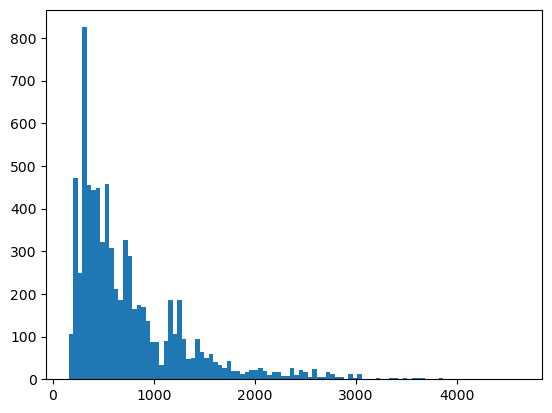

In [25]:
b_median = np.median(b)
print(b_median, len(b), len(np.where(b <= b_median)[0]), len(np.unique(b)))
plt.hist(b, bins=100);

In [24]:
len(np.unique(b))

969